In [40]:
import pandas as pd
import numpy as np
from scipy.stats import beta, weibull_min
from datetime import timedelta

In [41]:
df_path='../data/data_wind_solar_2024_25.csv'

df = pd.read_csv(df_path, sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df["Datum"] = df['Datum'].dt.tz_localize(None)
df.set_index('Datum', inplace=True)
df.columns = ['Wind', 'Solar']
day = None
if day is None:
    day = df.index[0] + timedelta(days=int(365/2))  # middle of the year
day = pd.to_datetime(day)

# normalize wind and solar to [0,1]
df = df.copy()
df['Wind'] = df['Wind'].clip(lower=0) / (df['Wind'].max() + 1e-9)
df['Solar'] = df['Solar'].clip(lower=0) / (df['Solar'].max() + 1e-9)


In [42]:
# Select ±1 month window
start = day - pd.DateOffset(months=1)
end = day + pd.DateOffset(months=1)
df_window = df.loc[start:end]

In [43]:
# resample to hourly data
df_s = df_window['Solar']
df_s = df_s.groupby([df_s.index.hour]).apply(list)

In [44]:
def get_alpha_beta_mean(data, thresh=0.02):
    if np.mean(data) < thresh:
        return 0.0
    a, b, loc, scale = beta.fit(data)
    mean = beta.mean(a, b, loc=loc, scale=scale)
    return mean

In [45]:
# df_s.apply(lambda x: get_alpha_beta_mean(x))

In [46]:
df_w = df_window['Wind']
df_w = df_w.groupby([df_w.index.hour]).mean()

In [47]:
df_bat = pd.read_csv('../data/battery_soc_profile.csv', sep=';')


In [48]:
from time_varying_dc_gain import get_wind_solar_dc_gains

In [49]:
path='../data/data_wind_solar_2024_25.csv'
df = pd.read_csv(path, sep=';')
df.drop('endTime', inplace=True, axis=1)
df.rename(columns={'startTime': 'Datum'}, inplace=True)
df["Datum"] = pd.to_datetime(df["Datum"], format='mixed')
df.set_index('Datum', inplace=True)
df.columns = ['Wind', 'Solar']
# normalize by max values
max_vals = df.max()
df_mean = df / max_vals

In [50]:
df_bat = pd.read_csv('../data/battery_soc_profile.csv', sep=';', index_col=0)
df_bat.loc[24, 'Battery_SOC (MWh)']

3.5

In [51]:
idx=101
print(df_mean.index[idx].weekday(), df_mean.index[idx].hour, df_mean.index[idx].minute)

3 23 15


## check forecast vs. realization for wind

In [52]:
path='../data/data_wind_solar_2024_25_forecast.csv'
df_forecast = pd.read_csv(path, sep=';')
df_forecast.drop('endTime', inplace=True, axis=1)
df_forecast.rename(columns={'startTime': 'Datum'}, inplace=True)
df_forecast["Datum"] = pd.to_datetime(df_forecast["Datum"], format='mixed')
df_forecast.set_index('Datum', inplace=True)
df_forecast.columns = ['Wind_forecast', 'Solar_forecast']

In [53]:
import matplotlib.pyplot as plt

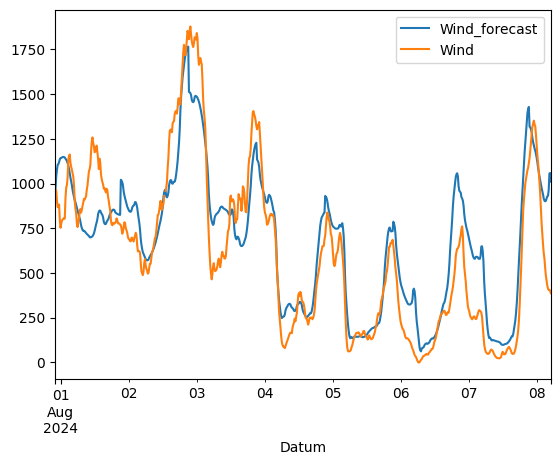

In [54]:
# compare wind forecast vs. realization for first week, i.e. ca. 700 indexes
df_forecast['Wind_forecast'].iloc[0:700].plot()
df['Wind'].iloc[0:700].plot()
plt.legend()
plt.show()

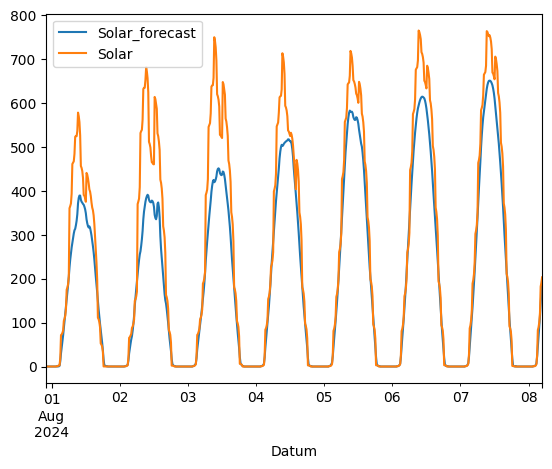

In [55]:
# compare solar forecast vs. realization for first week, i.e. ca. 700 indexes
df_forecast['Solar_forecast'].iloc[0:700].plot()
df['Solar'].iloc[0:700].plot()
plt.legend()
plt.show()  

In [62]:
# normalize
wind_max, solar_max = df.max()
df_forecast['Wind_forecast'] = df_forecast['Wind_forecast'] / wind_max
df_forecast['Solar_forecast'] = df_forecast['Solar_forecast'] / solar_max
df['Wind'] = df['Wind'] / wind_max
df['Solar'] = df['Solar'] / solar_max

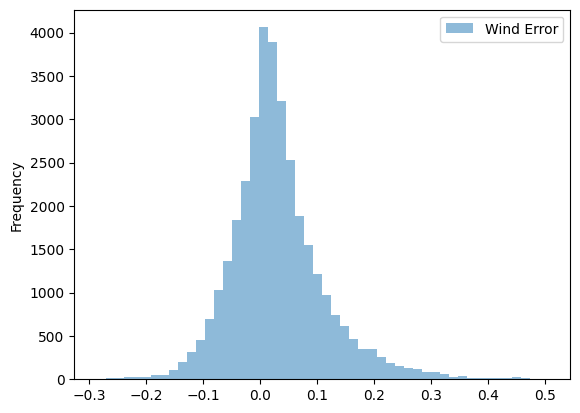

In [63]:
# plot error distribution for all timesteps
error_wind = df_forecast['Wind_forecast'] - df['Wind']
error_solar = df_forecast['Solar_forecast'] - df['Solar']
error_wind.plot(kind='hist', bins=50, alpha=0.5, label='Wind Error')
plt.legend()
plt.show()

In [87]:
# split by hour of day
hourly_error_wind = error_wind.groupby([error_wind.index.hour]).apply(list)
hourly_error_solar = error_solar.groupby([error_solar.index.hour]).apply(list)

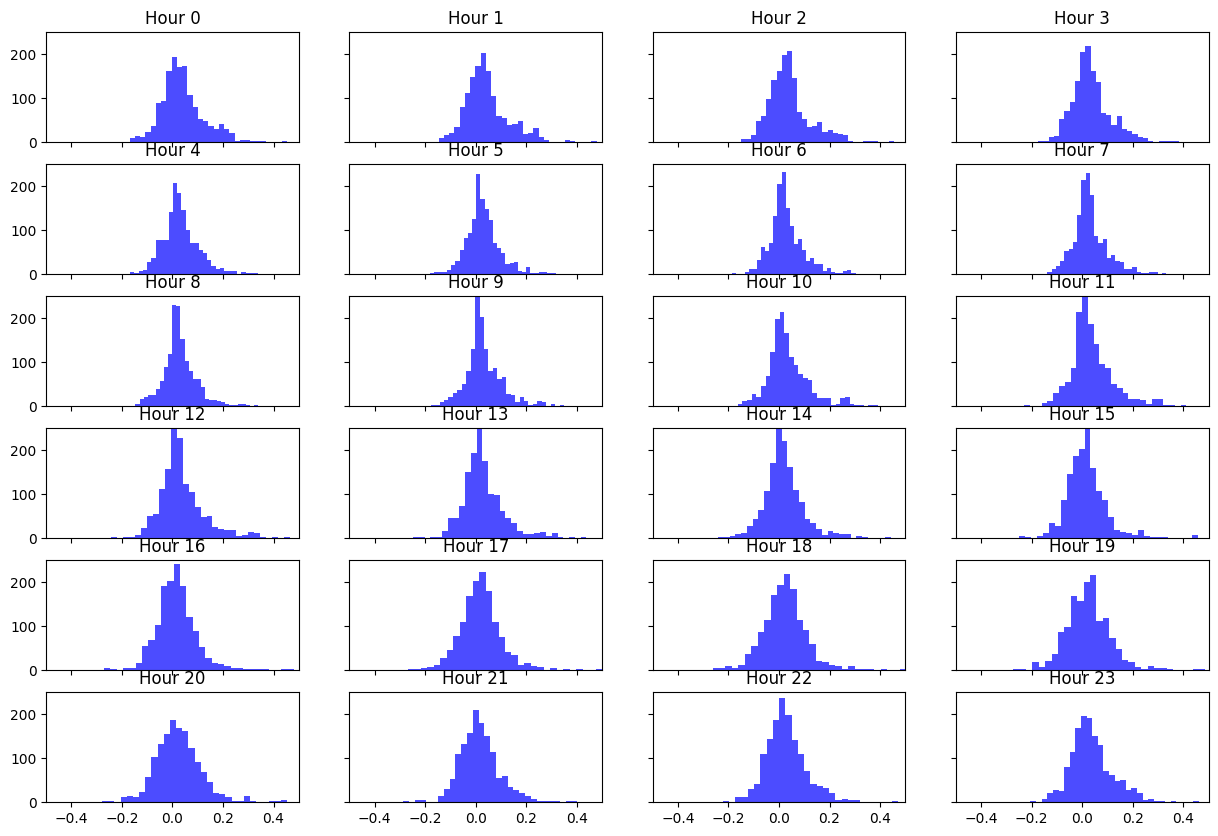

In [91]:
# plot for every hour historgram
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 4, figsize=(15, 10), sharex=True, sharey=True)
for hour in range(24):
    ax = axs[hour // 4, hour % 4]
    ax.hist(hourly_error_wind[hour], bins=30, alpha=0.7, color='blue')
    ax.set_title(f'Hour {hour}')
    ax.set_xlim([-.5, .5])
    ax.set_ylim([0, 250])

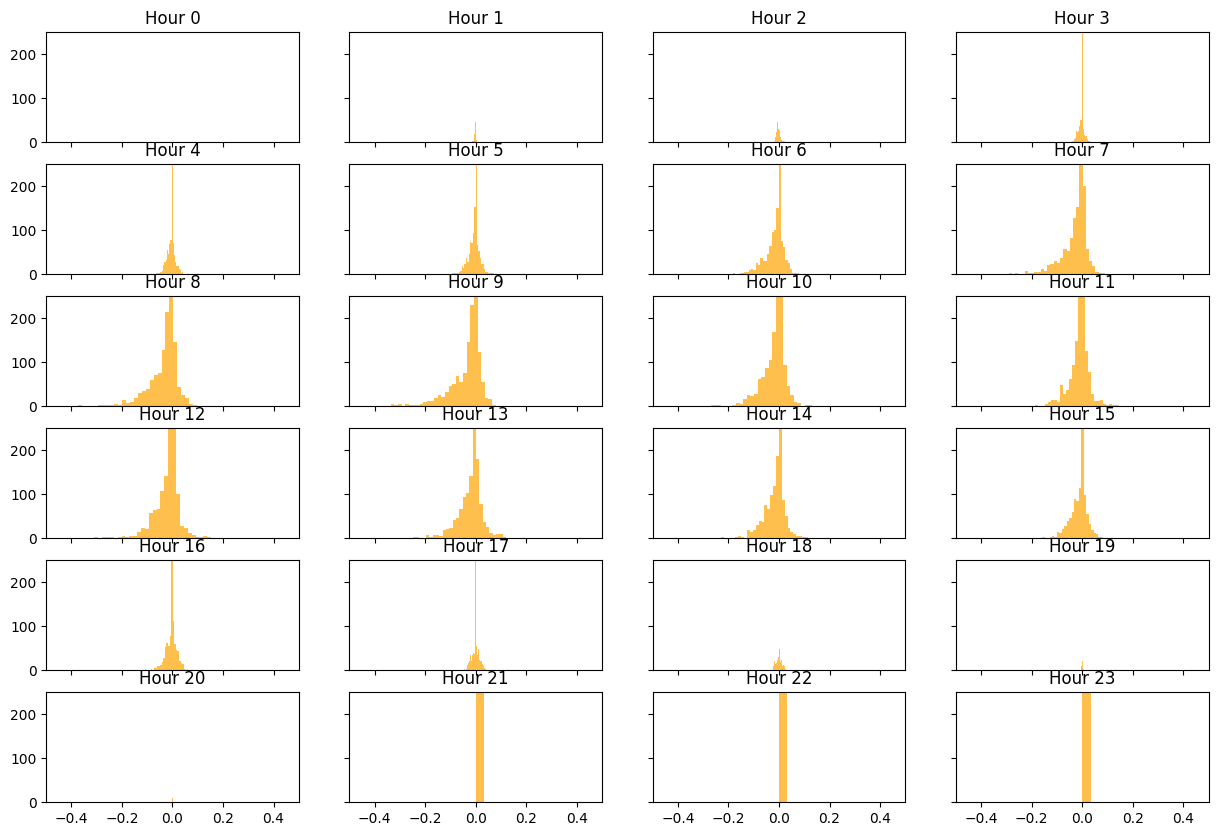

In [92]:
# plot for every hour historgram
fig, axs = plt.subplots(6, 4, figsize=(15, 10), sharex=True, sharey=True)
for hour in range(24):
    ax = axs[hour // 4, hour % 4]
    ax.hist(hourly_error_solar[hour], bins=30, alpha=0.7, color='orange')
    ax.set_title(f'Hour {hour}')
    ax.set_xlim([-.5, .5])
    ax.set_ylim([0, 250])

In [ ]:
print(f"Wind mean is {error_wind.mean():<.4f}, std is {error_wind.std():<.4f}")


mean is 0.0303, std is 0.0826


In [66]:
print(f'Solar mean is {error_solar.mean():<.4f}, std is {error_solar.std():<.4f}')

Solar mean is -0.0088, std is 0.0320


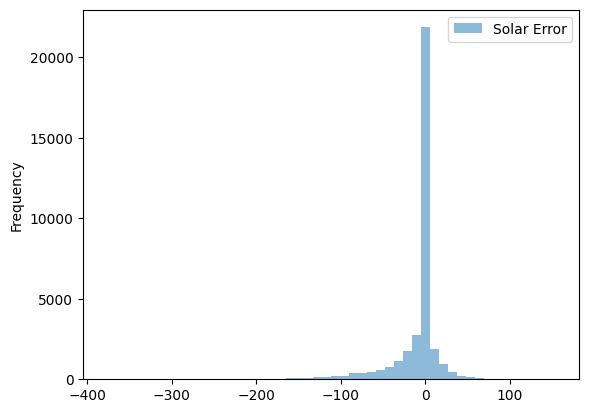

In [25]:
error_solar.plot(kind='hist', bins=50, alpha=0.5, label='Solar Error')
plt.legend()
plt.show()

In [74]:
data.isna().sum()

4610

In [75]:
len(data)

39266

array([-0.01571243,  0.00098964,  0.011298  , ..., -0.04994126,
       -0.0156768 , -0.00830887])

--- Descriptive Statistics (Measures of Shape) ---
Sample Size (n): 34656
Sample Mean: 0.0303
Sample Standard Deviation: 0.0826
--------------------------------------------------
Skewness (Ideal: ~0): 0.9388
Excess Kurtosis (Ideal: ~0): 2.8940

Interpretation:
 - Skewness close to 0 suggests good symmetry.
 - Excess Kurtosis close to 0 suggests tail heaviness similar to a normal distribution.

--- Shapiro-Wilk Normality Test ---
Test Statistic (W): 0.9481
P-value: 0.0000
--------------------------------------------------
Conclusion: Reject H0 (p <= 0.05). The data is likely NOT normally distributed.


C:\Users\carlv\AppData\Roaming\Python\Python311\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34656.
  res = hypotest_fun_out(*samples, **kwds)


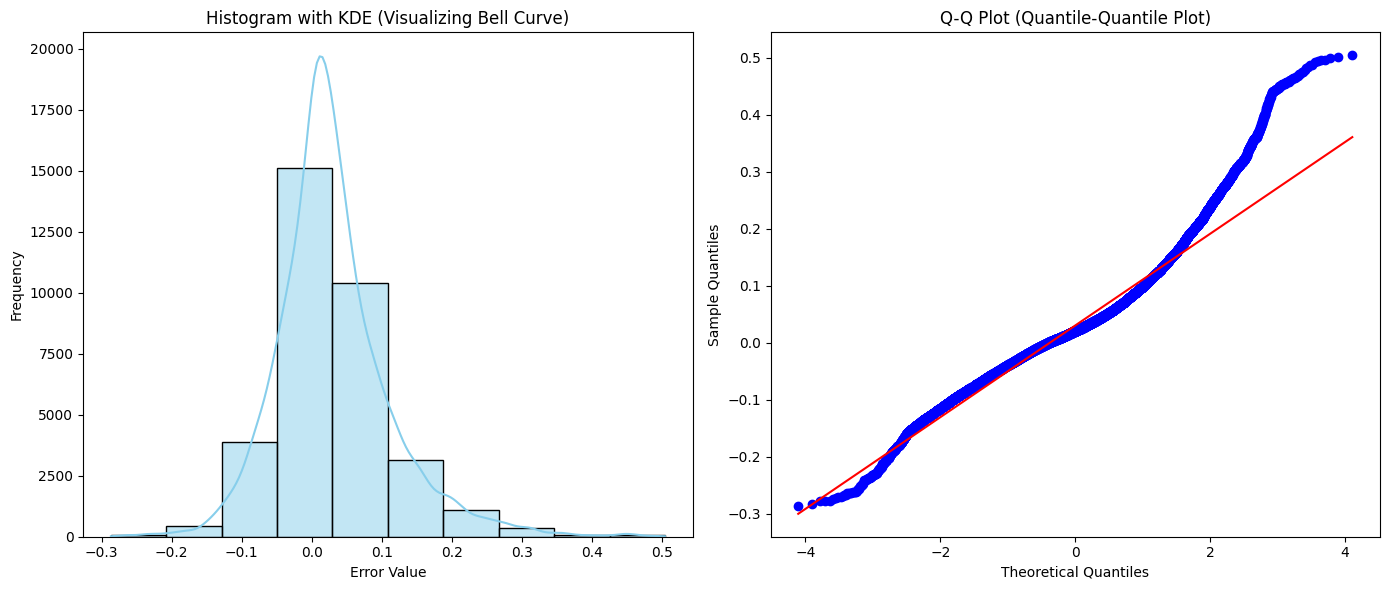


--- Visual Check Guidance ---
 - Histogram: Should look roughly symmetrical and bell-shaped.
 - Q-Q Plot: Data points should closely follow the straight red line for normality.


In [78]:
import numpy as np
from scipy.stats import shapiro, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns


data = error_wind[~error_wind.isna()].values
data_size = len(data)

# --- 1. Descriptive Statistics (Skewness and Kurtosis) ---
# Skewness: Should be close to 0 for a normal distribution (measures symmetry).
# Kurtosis: Excess Kurtosis (calculated by default in scipy) should be close to 0 (measures peakedness/tail heaviness).
data_skew = skew(data)
data_kurtosis = kurtosis(data)

print(f"--- Descriptive Statistics (Measures of Shape) ---")
print(f"Sample Size (n): {data_size}")
print(f"Sample Mean: {np.mean(data):.4f}")
print(f"Sample Standard Deviation: {np.std(data):.4f}")
print("-" * 50)
print(f"Skewness (Ideal: ~0): {data_skew:.4f}")
print(f"Excess Kurtosis (Ideal: ~0): {data_kurtosis:.4f}")
print("\nInterpretation:")
print(" - Skewness close to 0 suggests good symmetry.")
print(" - Excess Kurtosis close to 0 suggests tail heaviness similar to a normal distribution.")

# --- 2. Formal Statistical Test (Shapiro-Wilk) ---
# The Shapiro-Wilk test is a reliable test for normality.
# Null Hypothesis (H0): The data is drawn from a normal distribution.
# Alternative Hypothesis (Ha): The data is NOT drawn from a normal distribution.
stat, p = shapiro(data)

print(f"\n--- Shapiro-Wilk Normality Test ---")
print(f"Test Statistic (W): {stat:.4f}")
print(f"P-value: {p:.4f}")
print("-" * 50)

# Check the P-value against a significance level (alpha, typically 0.05)
alpha = 0.05
if p > alpha:
    print(f"Conclusion: Fail to reject H0 (p > {alpha}). It is reasonable to assume the data is normally distributed.")
else:
    print(f"Conclusion: Reject H0 (p <= {alpha}). The data is likely NOT normally distributed.")

# --- 3. Visual Check (Q-Q Plot and Histogram) ---
# Visual inspection is always recommended alongside statistical tests.
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data, kde=True, bins=10, color='skyblue')
plt.title('Histogram with KDE (Visualizing Bell Curve)')
plt.xlabel('Error Value')
plt.ylabel('Frequency')

# Q-Q Plot
plt.subplot(1, 2, 2)
from scipy.stats import probplot
probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot (Quantile-Quantile Plot)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.tight_layout()
plt.show()

print("\n--- Visual Check Guidance ---")
print(" - Histogram: Should look roughly symmetrical and bell-shaped.")
print(" - Q-Q Plot: Data points should closely follow the straight red line for normality.")

In [28]:
error_solar.mean(), error_solar.std()

(-8.884626141552511, 32.53443521588631)

# format data

In [19]:
def block_bootstrap_scenarios(residuals, forecast, N=10, block_size=4):
    """
    residuals: np.ndarray of shape (num_days, num_hours)
    forecast: np.ndarray of shape (num_hours,)
    N: number of scenarios to generate
    block_size: number of consecutive hours per block
    """
    num_days, num_hours = residuals.shape
    scenarios = []

    for i in range(N):
        e = np.zeros(num_hours)
        pos = 0
        while pos < num_hours:
            # Randomly choose a day and start hour
            d = np.random.randint(0, num_days)
            start = np.random.randint(0, num_hours - block_size + 1)

            # Select block
            block = residuals[d, start:start + block_size]

            # Fill into error trajectory
            end = min(pos + block_size, num_hours)
            e[pos:end] = block[:end - pos]
            pos += block_size

        # Add residuals to forecast
        y = forecast + e
        scenarios.append(y)

    scenarios = np.array(scenarios)
    probs = np.ones(N) / N  # uniform probabilities
    return scenarios, probs

In [20]:
df_forecast

,Wind_forecast,Solar_forecast
Datum,,
2024-07-31 22:00:00+00:00,856.6,0.0
2024-07-31 22:15:00+00:00,975.2,0.0
2024-07-31 22:30:00+00:00,1041.7,0.0
2024-07-31 22:45:00+00:00,1078.4,0.0
2024-07-31 23:00:00+00:00,1105.0,0.0
...,...,...
2025-07-31 20:45:00+00:00,1642.0,0.0
2025-07-31 21:00:00+00:00,1414.7,0.0
2025-07-31 21:15:00+00:00,1424.6,0.0


In [21]:
df

,Wind,Solar
Datum,,
2024-07-31 22:00:00+00:00,970.819,0.0
2024-07-31 22:15:00+00:00,968.006,0.0
2024-07-31 22:30:00+00:00,959.571,0.0
2024-07-31 22:45:00+00:00,902.011,0.0
2024-07-31 23:00:00+00:00,867.776,0.0
...,...,...
2025-09-13 20:45:00+00:00,NaN,0.0
2025-09-13 21:00:00+00:00,NaN,0.0
2025-09-13 21:15:00+00:00,NaN,0.0


## bid opt section

In [22]:
import numpy as np
from scipy.optimize import minimize_scalar

# Example data
p = np.array([0.1, 0.2, 0.3, 0.4])   # probabilities for each k
b_k = np.array([0.34, 0.7, 1.0, 1.5]) # threshold values for comparison
pi = 100                             # historic average price

# Expected reward function
def expected_reward(b, p, b_k, pi):
    # reward depends on whether b_k >= b
    r_k = np.where(b_k >= b, b * pi, -3 * b * pi)
    return np.sum(p * r_k)

# Objective for optimization (maximize reward)
def objective(b):
    return -expected_reward(b, p, b_k, pi)

# Optimize within a reasonable range
res = minimize_scalar(objective, bounds=(0, max(b_k) * 1.5), method='bounded')

b_opt = res.x
reward_opt = -res.fun

print(f"Optimal bid b*: {b_opt:.4f}")
print(f"Maximum expected reward: {reward_opt:.4f}")


Optimal bid b*: 0.7000
Maximum expected reward: 41.9999


In [23]:
b = 0.7
expected_reward(b, p, b_k, pi)

42.0